## Comparing new PLCO and old PLCO sizes and file names

In [1]:
updated_path = '/Mounts/rbg-storage1/datasets/PLCO_XRAY/allxrays/'

In [10]:
old_path = "/Mounts/rbg-storage1/datasets/PLCO_XRAY/tifs/"
old_json = "/Mounts/rbg-storage1/datasets/PLCO_XRAY/metadata_2022_04_05_rotated.json"

In [11]:
from glob import glob
import json
import pandas as pd
import skimage
from skimage.util import img_as_ubyte
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import pydicom

In [4]:
im_names = [pth.replace('/Mounts/rbg-storage1/datasets/PLCO_XRAY/allxrays/', "") for pth in glob(updated_path + "*.tif")]

In [5]:
im_names[0]

'AH04082092107142739_v2.tif'

In [6]:
old_json = json.load(open(old_json, 'rb'))

In [7]:
old_im_names = []
for patient in old_json:
    for accession in patient['accessions']:
        for img_series in accession['image_series']:
            old_im_names.append(img_series['filename'])

In [20]:
old_json[0]

AttributeError: 'str' object has no attribute 'keys'

In [9]:
set_old_im_names = set(old_im_names)

In [10]:
len(set_old_im_names)

89716

In [11]:
trues = 0
falses = 0
for im_name in im_names:
    if im_name in set_old_im_names:
        trues += 1
    else:
        falses += 1

In [12]:
trues, falses

(89716, 108824)

In [29]:
patient2image = '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Standard 25K Linkage (2021)/link_2021_25k_selection.csv'

In [30]:
new_patient2image = "/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Lung X-Ray Images (custom selection only)/lung_xry_images.csv"

In [31]:
df = pd.read_csv(patient2image)

In [32]:
df.head()

,assoc_visit_syr,assoc_visit_visnum,image_file_name,plco_id,batch_number
0,2,1,AH06587042606020354_v2.tif,Y-019806-1,2A
1,2,1,AH06587042606020542_v2.tif,Y-019806-1,2A
2,1,1,AH06587042606020631_v2.tif,Y-019806-1,2B
3,1,1,AH06587042606020813_v2.tif,Y-019806-1,2B
4,0,1,AH06587042606020900_v2.tif,Y-019806-1,2B


In [43]:
len(df['plco_id'].values)

89716

In [34]:
new_df = pd.read_csv(new_patient2image)

In [35]:
new_df.head()

,study_yr,image_file_name,image_file_size,in_ccsub_selection,plco_id,build
0,0,AE06278022406075831_v2,10427000,0,A-000899-7,aug21/09.15.21
1,1,AE06278022406080027_v2,10423000,0,A-000899-7,aug21/09.15.21
2,2,AE06278022406080212_v2,10431000,0,A-000899-7,aug21/09.15.21
3,3,AE06278022406080424_v2,10435000,0,A-000899-7,aug21/09.15.21
4,0,AD04658032006100221_v2,10373000,0,A-003887-9,aug21/09.15.21


In [36]:
len(set(new_df['plco_id'].values))

25000

In [42]:
set(new_df['image_file_name'].values) - set([n.replace(".tif", "") for n in df['image_file_name'].values])

set()

In [8]:
im_paths = glob(updated_path + "*.tif")

In [17]:
i = np.random.randint(0,198540)
path = im_paths[i]

In [18]:
path

'/Mounts/rbg-storage1/datasets/PLCO_XRAY/allxrays/AE04042120506081110_v2.tif'

## Finding dataset statistics

In [10]:
height, width = (512, 512)
resize = A.Resize(height, width)

In [11]:
means = []
stds = []
for p in tqdm(im_paths[:len(im_paths)//100]):
    im = skimage.io.imread(p, plugin='tifffile')
    im = exposure.rescale_intensity(im, in_range='uint12').astype(np.float64)
    out = resize(image=im)['image']
    means.append(np.mean(out))
    stds.append(np.std(out))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1985/1985 [03:37<00:00,  9.12it/s]


In [12]:
np.mean(means), np.mean(stds)

(45819.16578367201, 14211.166097275762)

In [ ]:
(2863.070033296751, 887.966694489157)

In [27]:
equalize = A.Equalize(always_apply=True)

In [118]:
means = []
stds = []
for p in tqdm(im_paths[:len(im_paths)//100]):
    im = skimage.io.imread(p, plugin='tifffile')
    im = resize(image=im)['image']
    im8 = im.astype(np.uint8)
    out = equalize(image=im.astype(np.uint8))['image']
    means.append(np.mean(out))
    stds.append(np.std(out))
    break

 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1551/1985 [02:04<00:34, 12.45it/s]


KeyboardInterrupt: 

## Scaling pixel values over dtype range

In [112]:
im

array([[   0,    0,    0, ..., 3848, 3848, 3848],
       [   0,    0,    0, ..., 3848, 3848, 3848],
       [   0,    0,    0, ..., 3848, 3848, 3848],
       ...,
       [3837, 3848, 3848, ..., 3848, 3848, 3848],
       [3837, 3848, 3848, ..., 3848, 3848, 3848],
       [3837, 3848, 3848, ..., 3848, 3848, 3848]], dtype=uint16)

In [113]:
image = exposure.rescale_intensity(im, in_range='uint12')

In [115]:
image.astype(np.float64)

array([[    0.,     0.,     0., ..., 61582., 61582., 61582.],
       [    0.,     0.,     0., ..., 61582., 61582., 61582.],
       [    0.,     0.,     0., ..., 61582., 61582., 61582.],
       ...,
       [61406., 61582., 61582., ..., 61582., 61582., 61582.],
       [61406., 61582., 61582., ..., 61582., 61582., 61582.],
       [61406., 61582., 61582., ..., 61582., 61582., 61582.]])

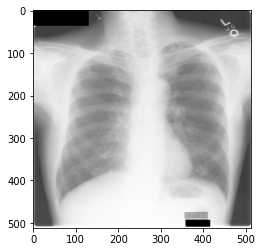

In [76]:
plt.imshow(im, cmap='gray')

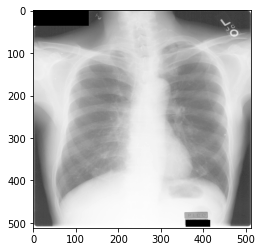

In [79]:
plt.imshow(image, cmap='gray')

#### 8 bits

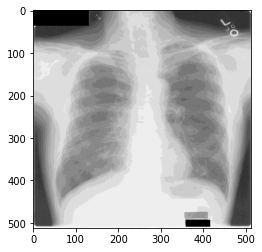

In [97]:
plt.imshow(img_as_ubyte(im), cmap='gray')

#### Scaled first then 8 bits

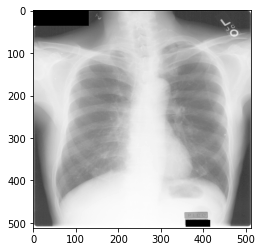

In [98]:
plt.imshow(img_as_ubyte(image), cmap='gray')

In [101]:
len(set(img_as_ubyte(image).reshape(-1).tolist()))

195

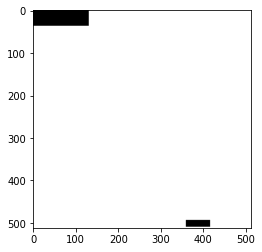

In [62]:
plt.imshow(image, cmap='gray')

In [30]:
np.mean(means), np.mean(stds)

(124.70010375976562, 75.47953517405743)

## Find Missing Metadata 

In [13]:
patient2image = '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Standard 25K Linkage (2021)/link_2021_25k_selection.csv'

In [14]:
files = glob('/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/*/*.csv')

In [ ]:
files

In [16]:
for file in files:
    df = pd.read_csv(file)
    print(file)
    print(len(set(df[['plco_id']].values.reshape(-1).tolist())))

/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Lung Screens (image only)/lung_screen.csv
70632
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Diagnostic Procedures/lung_proc_data_nov18_d070819.csv
15081
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Treatments/lung_trt_data_nov18_d070819.csv
3229
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Screening Abnormalities/lung_scrsub_data_nov18_d070819.csv
44592
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Lung Person (image only)/lung_prsn.csv
154887
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Standard 25K Linkage (2021)/link_2021_25k_selection.csv
25000
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Medical Complications/lung_med_data_nov18_d070819.csv
962


In [ ]:
df.head()

In [23]:
old_metadata = json.load(open(old_json, 'rb'))

In [26]:
old_pids = []
for patient in old_metadata:
    old_pids.append(patient['pid'])

In [27]:
len(old_pids)

25000

## Develop Windowing Loader

In [74]:
def apply_windowing(image, center, width, bit_size=16):
    import copy
    """Windowing function to transform image pixels for presentation.
    Must be run after a DICOM modality LUT is applied to the image.
    Windowing algorithm defined in DICOM standard:
    http://dicom.nema.org/medical/dicom/2020b/output/chtml/part03/sect_C.11.2.html#sect_C.11.2.1.2
    Reference implementation:
    https://github.com/pydicom/pydicom/blob/da556e33b/pydicom/pixel_data_handlers/util.py#L460
    Args:
        image (ndarray): Numpy image array
        center (float): Window center (or level)
        width (float): Window width
        bit_size (int): Max bit size of pixel
    Returns:
        ndarray: Numpy array of transformed images
    """
    y_min = 0
    y_max = 2**bit_size - 1
    y_range = y_max - y_min

    c = center - 0.5
    w = width - 1

    below = image <= (c - w / 2)  # pixels to be set as black
    above = image > (c + w / 2)  # pixels to be set as white
    between = np.logical_and(~below, ~above)
    
    image_copy = copy.deepcopy(image)
    image_copy[below] = y_min
    image_copy[above] = y_max
    if between.any():
        image_copy[between] = ((image_copy[between] - c) / w + 0.5) * y_range + y_min

    return image_copy


In [75]:
nlst_cxr_json_path = "/Mounts/rbg-storage1/datasets/ACRIN_XRAY/metadata_2022_04_10.json"

In [76]:
nlst_cxr_json = json.load(open(nlst_cxr_json_path, 'rb'))

In [77]:
nlst_cxr_json[0]['accessions'][0]['image_series'][0]['path']

'/Mounts/rbg-storage1/datasets/ACRIN_XRAY/NLST/2002-01__Studies/ _216290_CR_2002-01-01_120558_CHEST_CHEST_n1__00001/1.2.392.200036.9125.4.0.251798779.2717958144.103634967.dcm'

In [154]:
path = nlst_cxr_json[5]['accessions'][0]['image_series'][0]['path']

In [155]:
dcm = pydicom.dcmread(path)

In [157]:
dcm.pixel_array.min(), dcm.pixel_array.max(), dcm.pixel_array.mean()

(0, 4095, 2376.458543566795)

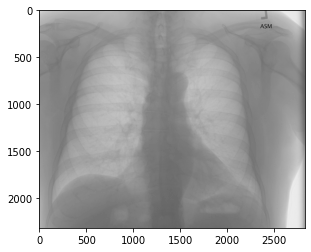

In [158]:
plt.imshow(dcm.pixel_array, cmap='gray')

In [159]:
dcm.RescaleSlope, dcm.RescaleIntercept

('1.0', '0.0')

In [134]:
pxl_arr = pydicom.pixel_data_handlers.util.apply_modality_lut(dcm.pixel_array, dcm)

In [141]:
np.all(pxl_arr == dcm.pixel_array)

True

In [142]:
pxl_arr.min(), pxl_arr.max(), pxl_arr.mean()

(71.0, 7362.0, 3972.6724463150645)

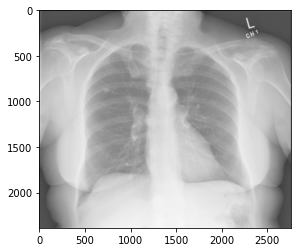

In [88]:
plt.imshow(pxl_arr, cmap='gray')

In [115]:
window_center = -600
window_width = 1500

In [122]:
arr = apply_windowing(pxl_arr, window_center, window_width, bit_size=12)

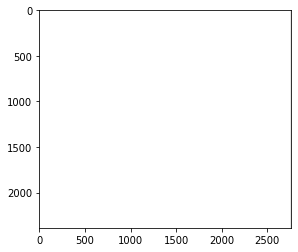

In [123]:
plt.imshow(arr, cmap='gray')

In [160]:
old_path = "/Mounts/rbg-storage1/datasets/PLCO_XRAY/tifs/"
old_json_path = "/Mounts/rbg-storage1/datasets/PLCO_XRAY/metadata_2022_04_05_rotated.json"

In [161]:
old_json = json.load(open(old_json_path, 'rb'))

In [164]:
old_json[0]['accessions'][0]['image_series'][0]['path']

'/Mounts/rbg-storage1/datasets/PLCO_XRAY/rotated_better_fix/batch_2e/AD02485080607140559_v2.tif'

In [165]:
plco_path = old_json[0]['accessions'][0]['image_series'][0]['path']

In [166]:
im = skimage.io.imread(plco_path, plugin='tifffile')

In [167]:
im.min(), im.max(), im.mean()

(0, 3848, 2916.240348405446)

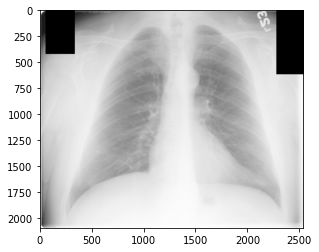

In [168]:
plt.imshow(im, cmap='gray')

In [169]:
im_rescaled = exposure.rescale_intensity(im, in_range='uint12').astype(np.float64)

In [172]:
im_rescaled.min(), im_rescaled.max(), im_rescaled.mean()

(0.0, 61582.0, 46670.044029216246)

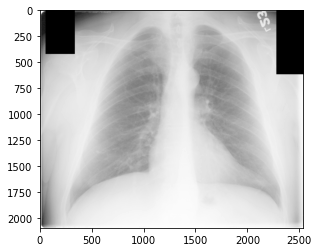

In [170]:
plt.imshow(im_rescaled, cmap='gray')

0.0 65535.0 51982.674979773976


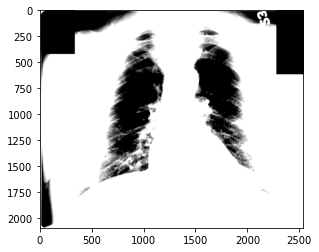

In [182]:
window_center = 40_000
window_width = 5_000
arr = apply_windowing(im_rescaled, window_center, window_width, bit_size=16)
print(arr.min(), arr.max(), arr.mean())
plt.imshow(arr, cmap='gray')

#### PLCO Window loader

In [ ]:
# load image
# scale to 16 bit
# window